In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical, SeveralSourceDataset
from data import data_dirs as data_env, get_label_with_context

from model import (
    LinkNet34,
    accuracy_segmentation, tensorboard_cb, test_showing, jaccard_index_one_class, jaccard_index_zero_class
)

from result_visualization import show_results

import torch
from torch.utils.data import DataLoader as t_Dataloader

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType, DataBunch,
    plt,    # matplotlib.pyplot
    nn,     # torch.nn
    optim,  # torch.optim
    Tensor, # torch.Tensor
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
sizes=256

train_data = SeveralSourceDataset([data_env.get_subdir("train_images"), data_env.get_subdir("train_images_p")], label_from_func=get_label_with_context, transforms=[],
                     batch_consistency=[15, 4], size=256)
valid_data = SeveralSourceDataset([data_env.get_subdir("val_images")], label_from_func=get_label_with_context,
                                 transforms=[], size=256, batch_consistency=[19])
t_dl = t_Dataloader(train_data, batch_size=19)
v_dl = t_Dataloader(valid_data, batch_size=19)

databunch = DataBunch(t_dl, v_dl)

In [3]:
model = LinkNet34(num_classes=2)

learner = Learner(databunch, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()  # pos_weight=Tensor([1])
learner.metrics = [accuracy_segmentation, jaccard_index_one_class, jaccard_index_zero_class]

# learner.freeze_to(1)

In [4]:
# learner.lr_find()
# learner.recorder.plot(suggestion=True, show_grid=True)

In [5]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="linknet34_osp_full_s256_mlr6e03_e10_bs19_student")

epoch,train_loss,valid_loss,accuracy_segmentation,jaccard_index_one_class,jaccard_index_zero_class,time
0,0.079646,0.306592,0.849617,69.813754,77.219171,06:04
1,0.069111,0.513911,0.894249,78.327776,82.966578,06:03
2,0.056309,0.448271,0.887425,77.652854,81.581918,06:02
3,0.037265,0.671046,0.890399,77.710800,82.356535,06:03
4,0.026778,0.424651,0.895613,78.968970,82.922240,06:03
5,0.020976,0.522890,0.886803,77.519920,81.510678,06:01
6,0.013333,0.607606,0.878291,76.272539,80.066498,06:11
7,0.008850,0.272603,0.915386,83.299443,85.419728,06:31
8,0.006708,0.436554,0.906931,81.749612,84.091674,06:28
9,0.005583,0.536669,0.902144,80.650712,83.534577,06:12


profiler execution failed


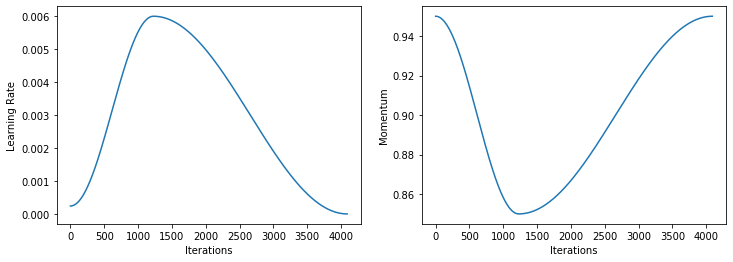

In [6]:
learner.fit_one_cycle(10, max_lr=6e-03, callbacks=[tb_callback(learner)])
learner.recorder.plot_lr(show_moms=True)

In [7]:
learner.save("/home/dmitri/Documents/model_weights/linknet34/linknet34_student_ops_full_e10_wghts")
# learner.export("/home/dmitri/Documents/model_weights/linknet34/linknet34_student_ops_full_e10_exp")